# Milestone 1 : Data Collection, Exploration, and Preprocessing

## 1.1  We will start by importing the kitti dataset from kaggle to work on the project on the cloud instead of locally

In [1]:
ls /kaggle/input/*/


data_object_calib/    data_object_image_3/
data_object_image_2/  data_object_label_2/


## Imported Necessary Libraries 

In [31]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
import random
from tqdm import tqdm
from imgaug import augmenters as iaa


In [5]:
label_dir = "/kaggle/input/kitti-dataset/data_object_label_2/training/label_2/"
image_dir = "/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/"

### Example image

In [6]:
def read_image_with_label(image_name):
    # Read the image
    image_path = os.path.join(image_dir, f"{image_name}.png") 
    image = cv2.imread(image_path)

    if image is None:
        raise FileNotFoundError(f"Not Found: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Read the corresponding label file
    label_path = os.path.join(label_dir, f"{image_name}.txt")
    
    # Draw bounding boxes if label file exists
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                data = line.strip().split()
                # KITTI format: [type truncation occlusion alpha x1 y1 x2 y2 h w l x y z rot_y]
                if len(data) >= 15:  # Ensure we have enough data
                    obj_type = data[0]
                    x1, y1, x2, y2 = float(data[4]), float(data[5]), float(data[6]), float(data[7])
                    
                    # Convert to integers for drawing
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    
                    # Draw rectangle
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
                    # Add label text
                    cv2.putText(image, obj_type, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    else:
        print(f"Warning: No label file found at {label_path}")
    
    print(f"Image shape: {image.shape}")
    return image

Image shape: (375, 1242, 3)
Image shape: (375, 1242, 3)
Image shape: (375, 1242, 3)
Image shape: (375, 1242, 3)
Image shape: (375, 1242, 3)
Image shape: (374, 1238, 3)
Image shape: (370, 1224, 3)
Image shape: (375, 1242, 3)
Image shape: (376, 1241, 3)


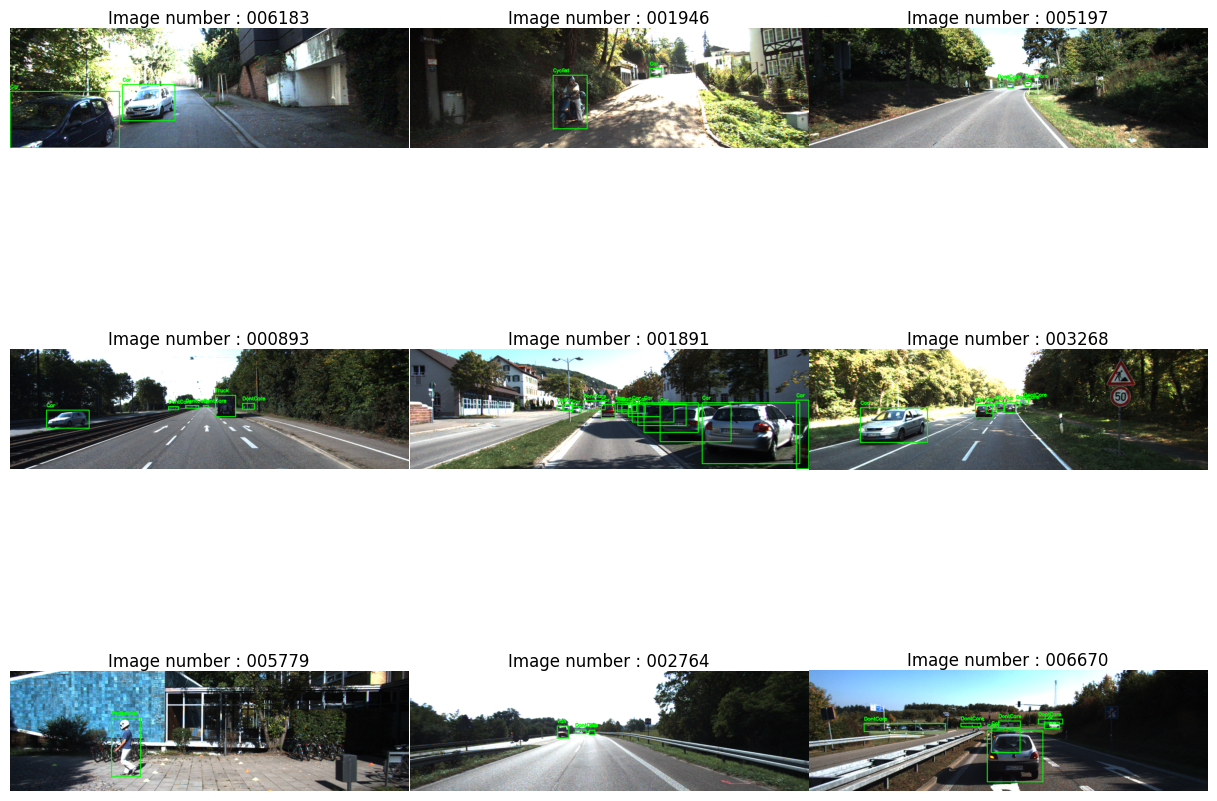

In [7]:
# Get random image names
img_files = [f.split('.')[0] for f in os.listdir(image_dir) if f.endswith('.png')]
selected = random.sample(img_files, min(9, len(img_files)))

# Create 3x3 plot with larger figure size
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

# Plot images with labels
for i, number in enumerate(selected):
    img = read_image_with_label(number)
    axes[i].imshow(img)
    axes[i].set_title(f"Image number : {number}", pad=2)  # Reduce title padding
    axes[i].axis('off')

# Maximize image space by reducing spacing and margins
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.05, hspace=0.1)

# Tight layout with minimal padding
plt.tight_layout(pad=0.1)
plt.show()

* Dataset has labelled bounding boxes for objects with different conditions 

## 1.2 Data Exploration 

### In order to know the distribution of objects we will count our class labels to understand the distrubtion

In [10]:
def label_counts_distribution():
    label_counts = Counter()
    for label_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, label_file), "r") as file:
            for line in file:
                class_name = line.split()[0] 
                label_counts[class_name] += 1 
    return label_counts

Distribution
Car: 28742
Van: 2914
DontCare: 11295
Misc: 973
Cyclist: 1627
Pedestrian: 4487
Truck: 1094
Tram: 511
Person_sitting: 222


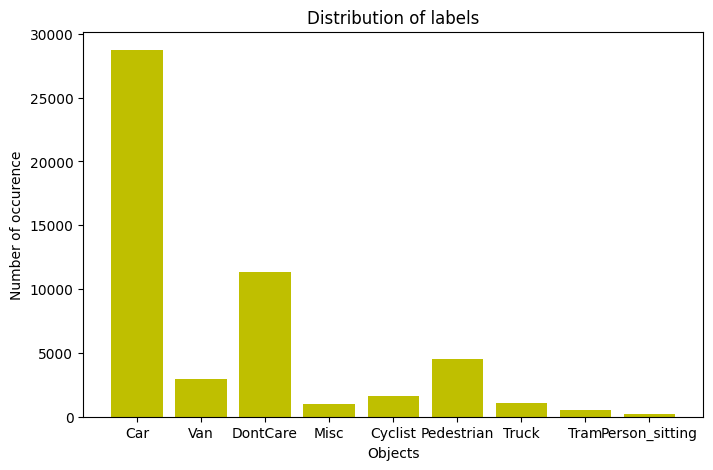

In [12]:
label_counts = label_counts_distribution()

print("Distribution")
for label, count in label_counts.items():
    print(f"{label}: {count}")

plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values(), color='y')
plt.xlabel("Objects")
plt.ylabel("Number of occurence")
plt.title("Distribution of labels")
plt.show()

The chart reveals significant class imbalance in the KITTI dataset, with cars dominating at approximately 29,000 instances, followed by DontCare annotations (~11,500) and pedestrians (~4,500). This imbalance reflects real-world urban driving scenarios but poses challenges for model training,  requiring class weighting or augmentation strategies to improve detection performance on small classes like Person_sitting and Tram.

### Data Quality investigations
* Loop over data to find different resolutions
* Check for biases 

In [15]:
# Image Resolution
def image_resolutions():
    resolutions = []
    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        img = cv2.imread(image_path)
    
        if img is not None:
            resolutions.append(img.shape[:2])
    return np.array(resolutions)

In [16]:
resolutions = image_resolutions()
unique_resolutions = np.unique(resolutions, axis=0)
print("Unique Image Resolutions:", unique_resolutions)

Unique Image Resolutions: [[ 370 1224]
 [ 374 1238]
 [ 375 1242]
 [ 376 1241]]


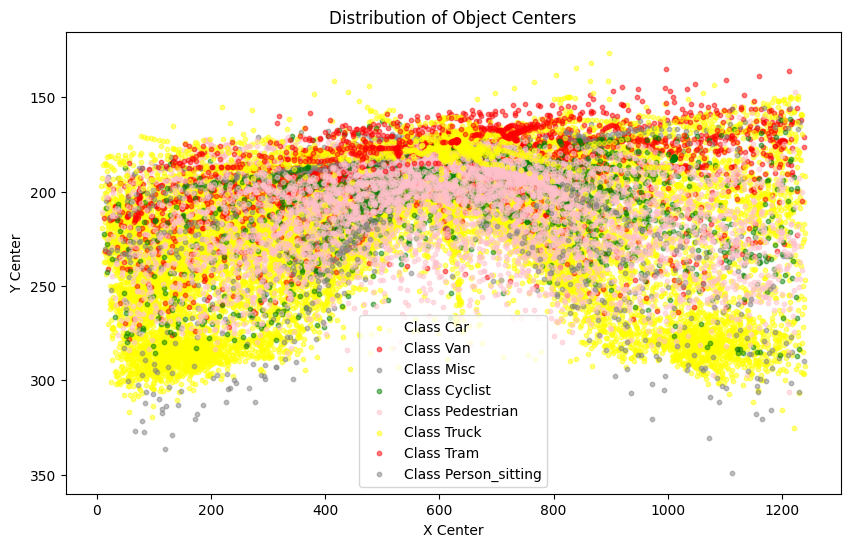

In [19]:
def detect_box_positions():
    bbox_positions = {}
    for label_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, label_file), "r") as file:
            for line in file:
                parts = line.split()
                class_id = parts[0]  
                x_min, y_min, x_max, y_max = map(float, parts[4:8])  

                x_center = (x_min + x_max) / 2
                y_center = (y_min + y_max) / 2

                if class_id != "DontCare":
                    if class_id not in bbox_positions:
                        bbox_positions[class_id] = []
                
                    bbox_positions[class_id].append((x_center, y_center))
    return bbox_positions

bbox_positions = detect_box_positions()

plt.figure(figsize=(10, 6))
colors = ['yellow', 'red', 'gray', 'green', 'pink']

for i, (class_id, positions) in enumerate(bbox_positions.items()):
    positions = np.array(positions)
    plt.scatter(positions[:, 0], positions[:, 1], alpha=0.5, s=10, color=colors[i % len(colors)], label=f"Class {class_id}")

plt.xlabel("X Center")
plt.ylabel("Y Center")
plt.title("Distribution of Object Centers")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

This scatter plot shows where different objects appear in images. Cars (yellow dots) are most common and spread across the whole frame. Most objects appear in the middle and lower parts of images

### Detect Biases


In [26]:
def extract_bounding_boxes_and_tags(imageName):
    bounding_boxes = [] 
    environment_tags = []
    road_type = ""
    label_path = f"{label_dir}{imageName}.txt"
    if os.path.exists(label_path):
        with open(label_path, "r") as file:
            for line in file:
                values = line.split()
                if values[0] != 'DontCare':
                    x_min, y_min, x_max, y_max = map(float, values[4:8])
                    bounding_boxes.append((x_min, y_min, x_max, y_max))
                    environment_tags = values[-4:-1] 
                    road_type = values[-1] 
    else:
        print(f"Not Found: {label_path}")

    return bounding_boxes, environment_tags, road_type


Image shape: (375, 1242, 3)


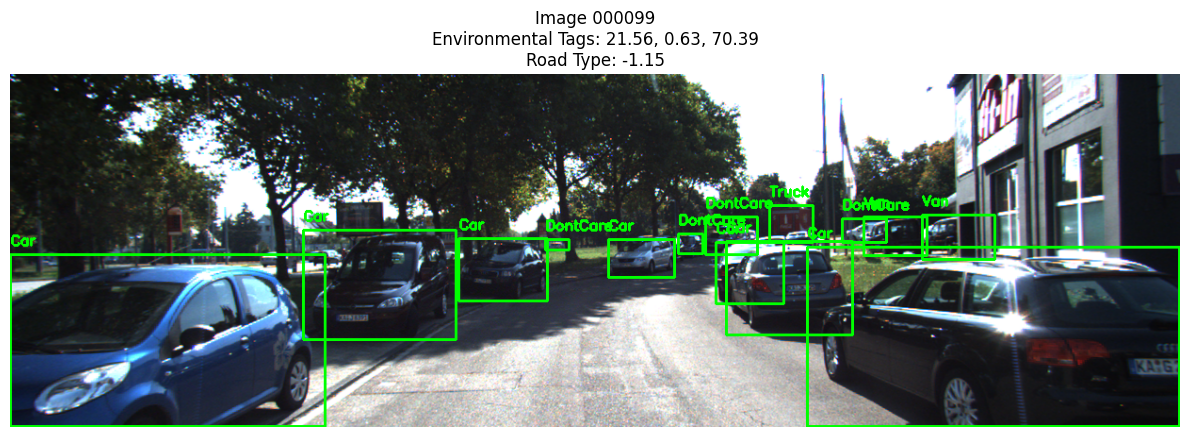

Analysis for image 000099:
Number of objects detected: 10
Environmental context: 21.56, 0.63, 70.39
Road type: -1.15


(array([[[ 44,  21,  24],
         [ 38,  32,   0],
         [ 35,  22,   0],
         ...,
         [ 57,  67,  79],
         [ 55,  66,  77],
         [ 55,  67,  78]],
 
        [[ 48,  25,  73],
         [ 47,  40, 209],
         [ 46, 102, 229],
         ...,
         [ 50,  67,  79],
         [ 51,  67,  78],
         [ 54,  67,  79]],
 
        [[ 19,  31,  51],
         [ 18,  26, 229],
         [ 38, 103, 255],
         ...,
         [ 51,  67,  80],
         [ 52,  68,  80],
         [ 54,  68,  80]],
 
        ...,
 
        [[  0, 255,   0],
         [  0, 255,   0],
         [ 12,  22,  48],
         ...,
         [ 12,  12,  11],
         [  0, 255,   0],
         [  0, 255,   0]],
 
        [[  0, 255,   0],
         [  0, 255,   0],
         [  0, 255,   0],
         ...,
         [  0, 255,   0],
         [  0, 255,   0],
         [  0, 255,   0]],
 
        [[  0, 255,   0],
         [  0, 255,   0],
         [  0, 255,   0],
         ...,
         [  0, 255,   0],
  

In [27]:
def analyze_environmental_factors(image_name):
    # Get image with labels already drawn
    img = read_image_with_label(image_name)
    
    # Extract environmental information
    bounding_boxes, environment_tags, road_type = extract_bounding_boxes_and_tags(image_name)
    
    # Format environmental information for display
    environment_info = ", ".join(environment_tags) if environment_tags else "N/A"
    title_text = f"Image {image_name}\nEnvironmental Tags: {environment_info}\nRoad Type: {road_type}"
    
    # Display the image with environmental information
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title_text)
    plt.tight_layout()
    plt.show()
    
    # Simple analysis of environment
    print(f"Analysis for image {image_name}:")
    print(f"Number of objects detected: {len(bounding_boxes)}")
    print(f"Environmental context: {environment_info}")
    print(f"Road type: {road_type}")
    
    return img, bounding_boxes, environment_tags, road_type

analyze_environmental_factors("000099")

## 1.3 Data Pre-Processing

In [30]:
def resize_all_images(input_dir, output_dir, target_size=416):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all image files
    image_files = [f for f in os.listdir(input_dir) if f.endswith('.png') or f.endswith('.jpg')]
    
    # Resize and save each image
    for img_file in tqdm(image_files, desc="Resizing images"):
        # Read image
        img_path = os.path.join(input_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image
        img_resized = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
        
        # Save resized image
        output_path = os.path.join(output_dir, img_file)
        cv2.imwrite(output_path, cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))
    
    print(f"Resized {len(image_files)} images to {target_size}x{target_size}")

#Apply function
resize_all_images(image_dir, "yolo_resized_images")

Resizing images: 100%|██████████| 7481/7481 [04:42<00:00, 26.47it/s]

Resized 7481 images to 416x416


### Data normalization and augmentation to prepare for modelling

In [32]:
def process_dataset(resized_dir, processed_dir, augment=True):
    # Create output directory
    os.makedirs(processed_dir, exist_ok=True)
    
    # Define augmentation sequence
    aug_seq = iaa.Sequential([
        iaa.Sometimes(0.5, iaa.Crop(percent=(0, 0.1))),
        iaa.Sometimes(0.5, iaa.Fliplr(1.0)),
        iaa.Sometimes(0.3, iaa.Affine(rotate=(-15, 15)))
    ])
    
    # Get all image files from the resized directory
    image_files = [f for f in os.listdir(resized_dir) if f.endswith('.png') or f.endswith('.jpg')]
    
    # Process each image
    for img_file in tqdm(image_files, desc="Processing images"):
        # Read already resized image
        img_path = os.path.join(resized_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Normalize to [0-1]
        img_norm = img.astype(np.float32) / 255.0
        
        # Apply augmentation if requested
        if augment:
            img_processed = aug_seq(image=img_norm)
        else:
            img_processed = img_norm
        
        # Convert back to [0-255] for saving
        img_processed = (img_processed * 255).astype(np.uint8)
        
        # Save processed image
        output_path = os.path.join(processed_dir, img_file)
        cv2.imwrite(output_path, cv2.cvtColor(img_processed, cv2.COLOR_RGB2BGR))
    
    print(f"Normalized and augmented {len(image_files)} images")


process_dataset("yolo_resized_images", "yolo_processed_images")

Processing images: 100%|██████████| 7481/7481 [03:19<00:00, 37.56it/s]

Normalized and augmented 7481 images


Image shape: (375, 1242, 3)


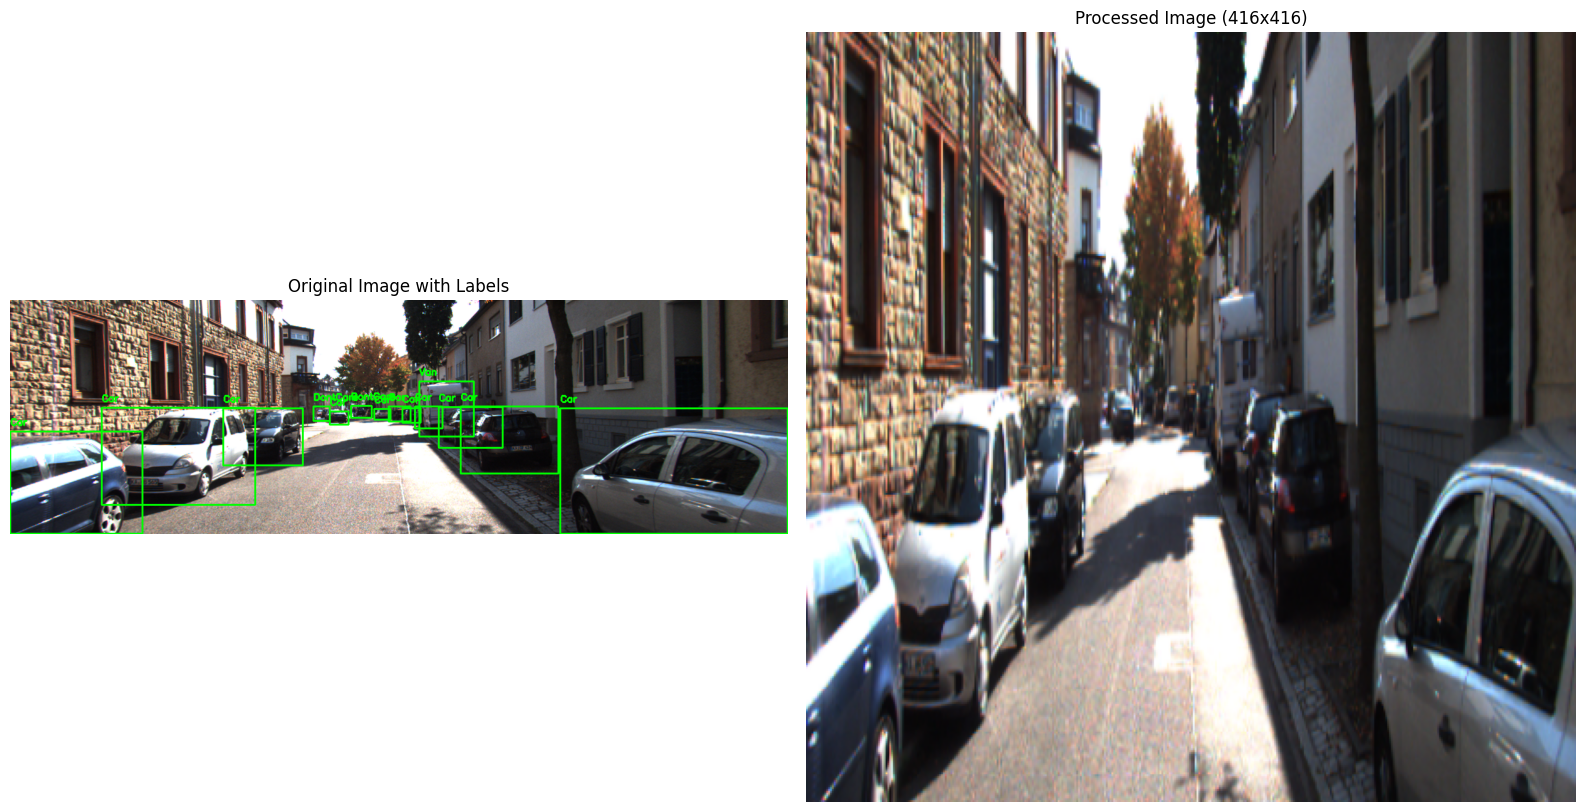

In [34]:
import os
import cv2
import matplotlib.pyplot as plt

# Image and label paths
processed_dir = "yolo_processed_images"
img_name = "001010"

# First use read_image_with_label to get original image with labels
original_with_labels = read_image_with_label(img_name)

# Then load the processed version of the same image
processed_img_path = os.path.join(processed_dir, f"{img_name}.png")
processed_img = cv2.imread(processed_img_path)
processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

# Display both images side by side for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Original image with labels
ax1.imshow(original_with_labels)
ax1.set_title("Original Image with Labels")
ax1.axis('off')

# Processed image
ax2.imshow(processed_img)
ax2.set_title("Processed Image (416x416)")
ax2.axis('off')

plt.tight_layout()
plt.show()

Image shape: (375, 1242, 3)


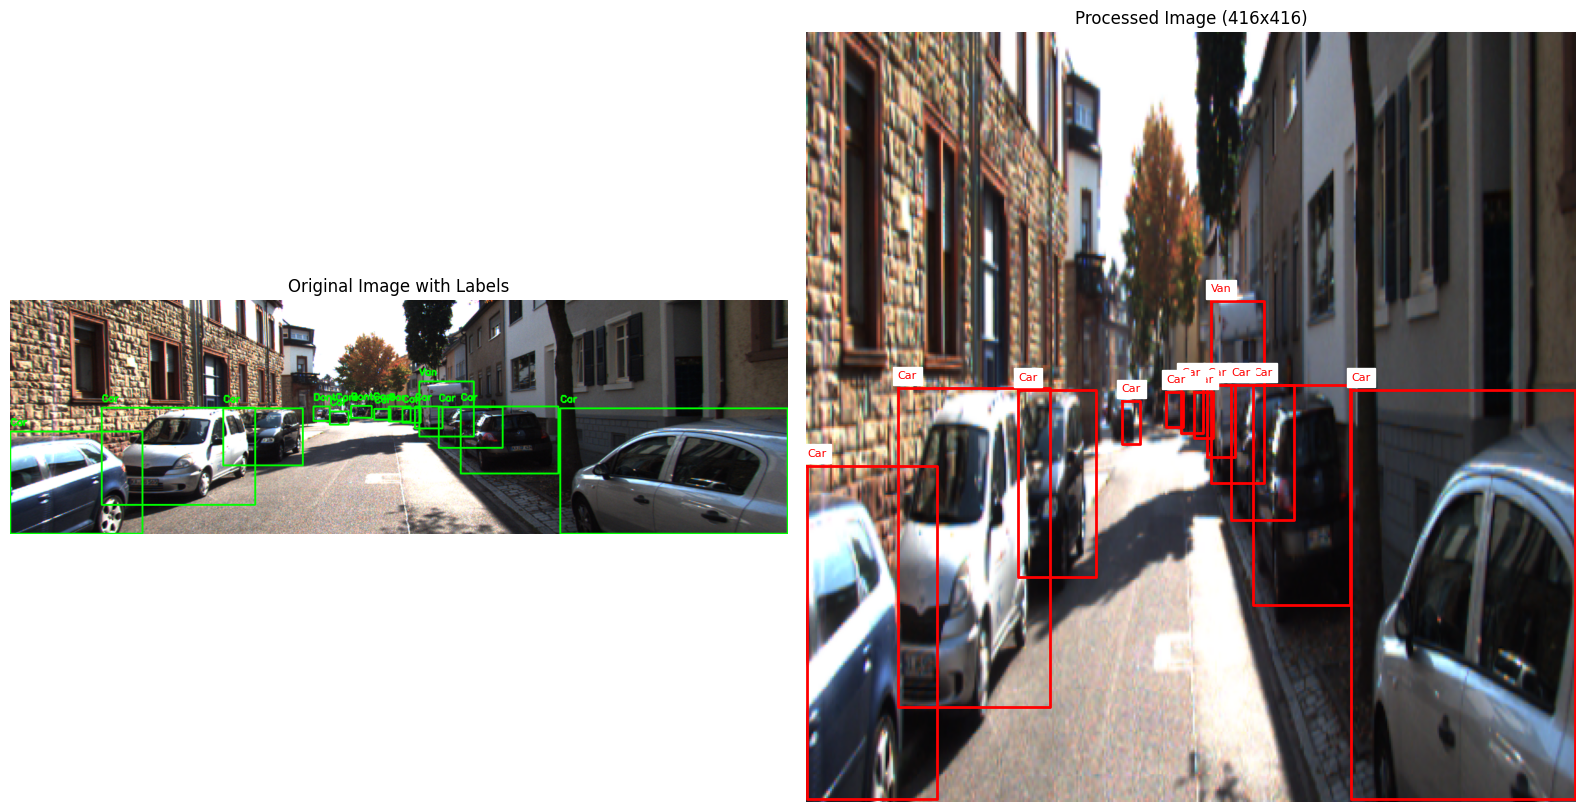

In [43]:
# Image and label paths
processed_dir = "yolo_processed_images"
img_name = "001010"
label_path = os.path.join(label_dir, f"{img_name}.txt")  # Make sure directory is defined

# First use read_image_with_label to get original image with labels
original_with_labels = read_image_with_label(img_name)

# Then load the processed version of the same image
processed_img_path = os.path.join(processed_dir, f"{img_name}.png")
processed_img = cv2.imread(processed_img_path)
processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

# Get original dimensions and processed dimensions for scaling
orig_h, orig_w = original_with_labels.shape[0], original_with_labels.shape[1]
proc_h, proc_w = processed_img.shape[0], processed_img.shape[1]  # Should be 416x416

# Display both images side by side for comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Original image with labels
ax1.imshow(original_with_labels)
ax1.set_title("Original Image with Labels")
ax1.axis('off')

# Processed image with labels
ax2.imshow(processed_img)
ax2.set_title("Processed Image (416x416)")
ax2.axis('off')

# Draw bounding boxes on processed image
if os.path.exists(label_path):
    with open(label_path, "r") as file:
        for line in file:
            values = line.split()
            if values[0] != 'DontCare':
                # Get original coordinates
                x_min, y_min, x_max, y_max = map(float, values[4:8])
                
                # Scale coordinates to processed dimensions
                x_min = int(x_min * proc_w / orig_w)
                x_max = int(x_max * proc_w / orig_w)
                y_min = int(y_min * proc_h / orig_h)
                y_max = int(y_max * proc_h / orig_h)
                
                # Draw rectangle on processed image
                ax2.plot([x_min, x_max, x_max, x_min, x_min], 
                         [y_min, y_min, y_max, y_max, y_min], 'r-', linewidth=2)
                ax2.text(x_min, y_min-5, values[0], color='red', 
                         backgroundcolor='white', fontsize=8)

plt.tight_layout()
plt.show()